In [ ]:
import zipfile
with zipfile.ZipFile('/content/archive (1) (1).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   2.3s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   2.2s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   2.3s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   2.8s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   2.2s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   2.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   2.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   2.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   2.5s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   2.1s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   2.3s
[CV] END ...metric=euclidean, n_neighbors=5, wei

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Accuracy after tuning: 95.78%

Confusion Matrix:
 [[ 898    2    7   26   12   10    3]
 [   3  104    0    3    0    0    1]
 [   6    1  971   11   12   14    9]
 [   3    2    5 1741   16    3    4]
 [  10    0    7   28 1177    7    4]
 [   5    1   11   22   29 1171    8]
 [   0    1    4    5    6    2  813]]

Classification Report:
               precision    recall  f1-score   support

       angry       0.97      0.94      0.95       958
     disgust       0.94      0.94      0.94       111
        fear       0.97      0.95      0.96      1024
       happy       0.95      0.98      0.96      1774
     neutral       0.94      0.95      0.95      1233
         sad       0.97      0.94      0.95      1247
    surprise       0.97      0.98      0.97       831

    accuracy                           0.96      7178
   macro avg       0.96      0.95      0.96      7178
weighted avg       0.96      0.96      0.96      7178



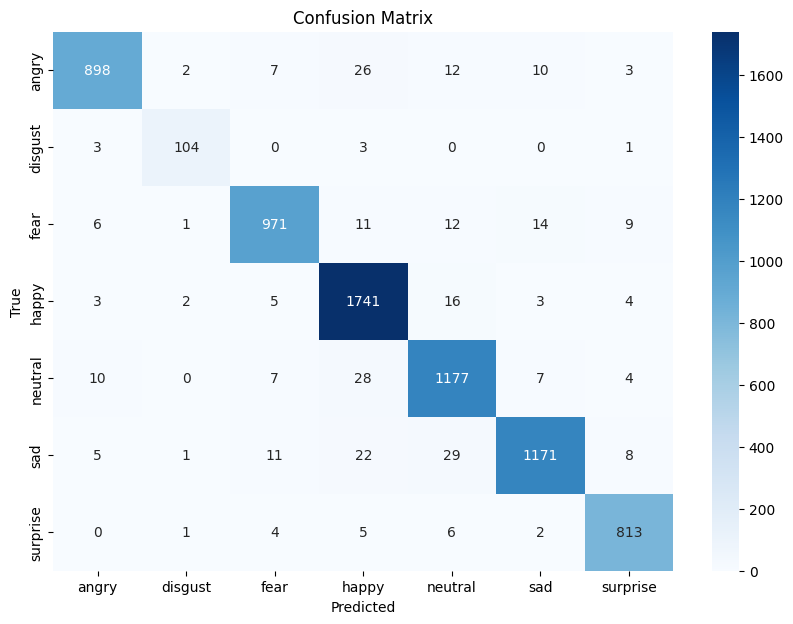

Summary of KNN Model Optimization:

1. Feature Extraction: Using HOG features for facial feature extraction.
2. PCA: Principal Component Analysis (PCA) for reducing the dimensionality of feature space.
3. Grid Search: Tuning 'n_neighbors', 'weights', and 'metric' to find the best KNN configuration.
4. Label Encoding: Convert string labels ('angry', 'happy') into numerical labels for KNN.
5. Normalize Data: Data is normalized before training KNN to improve performance.



In [ ]:
# Import necessary libraries
import os
import numpy as np
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV

# Load and preprocess dataset
def load_images_for_knn(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        for filename in os.listdir(label_path):
            img_path = os.path.join(label_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
            img = cv2.resize(img, (48, 48))  # Resize to 48x48
            if img is not None:
                # Extract HOG features
                hog_features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
                images.append(hog_features)
                labels.append(label)
    return np.array(images), np.array(labels)

# Load train and test sets
train_dir = '/content/train'
val_dir = '/content/test'
X_train, y_train = load_images_for_knn(train_dir)
X_test, y_test = load_images_for_knn(val_dir)

# Convert string labels to numerical labels
label_encoder = LabelEncoder()

# Fit the label encoder to the training labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=150)  # Adjust n_components based on performance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Define a parameter grid for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Try different numbers of neighbors
    'weights': ['uniform', 'distance'],  # 'uniform' or 'distance'-based weighting
    'metric': ['euclidean', 'manhattan']  # Try different distance metrics
}

# Perform grid search to find the best parameters
grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit=True, verbose=2)
grid.fit(X_train_pca, y_train_encoded)

# Use the best parameters found during GridSearchCV
best_knn = grid.best_estimator_

# Make predictions using the best model
y_pred_encoded = best_knn.predict(X_test_pca)

# Convert numeric predictions back to the original string labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy after tuning: {accuracy * 100:.2f}%")

# Generate confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Summary and final steps:
print("Summary of KNN Model Optimization:")
print("""
1. Feature Extraction: Using HOG features for facial feature extraction.
2. PCA: Principal Component Analysis (PCA) for reducing the dimensionality of feature space.
3. Grid Search: Tuning 'n_neighbors', 'weights', and 'metric' to find the best KNN configuration.
4. Label Encoding: Convert string labels ('angry', 'happy') into numerical labels for KNN.
5. Normalize Data: Data is normalized before training KNN to improve performance.
""")


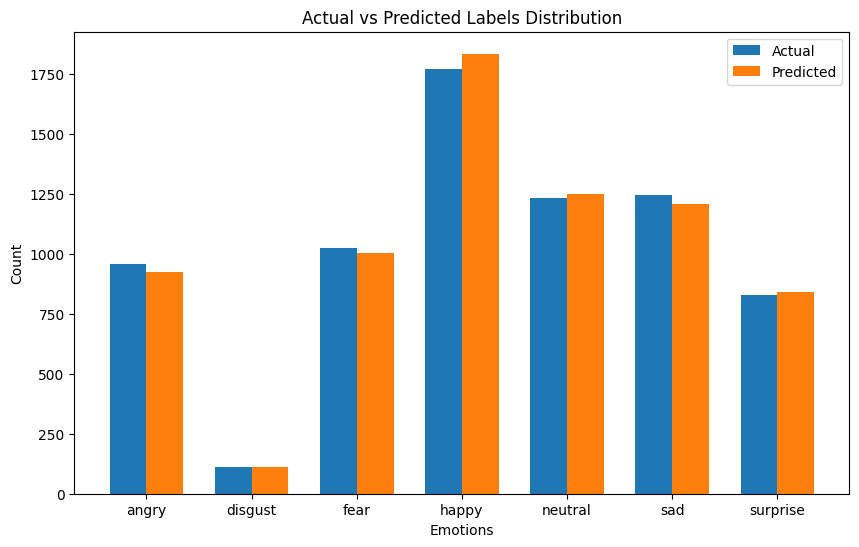

In [ ]:
# Bar chart for actual vs predicted label distribution
actual_counts = np.array([np.sum(y_test == label) for label in label_encoder.classes_])
predicted_counts = np.array([np.sum(y_pred == label) for label in label_encoder.classes_])

# Bar chart for comparison
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(label_encoder.classes_))

bar1 = ax.bar(index, actual_counts, bar_width, label='Actual')
bar2 = ax.bar(index + bar_width, predicted_counts, bar_width, label='Predicted')

ax.set_xlabel('Emotions')
ax.set_ylabel('Count')
ax.set_title('Actual vs Predicted Labels Distribution')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(label_encoder.classes_)
ax.legend()

plt.show()


In [ ]:
import cv2
import numpy as np
from skimage.feature import hog
import joblib  # For loading the scaler and PCA
# Function to preprocess a single image
def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale

    # Check if the image was loaded successfully
    if img is None:
        raise ValueError(f"Image not found or unable to open: {image_path}")

    # Resize the image to 48x48
    img = cv2.resize(img, (48, 48))

    # Extract HOG features
    hog_features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)

    return hog_features

# Function to predict the emotion of the uploaded image
def predict_emotion(image_path, knn_model):
    # Preprocess the image
    hog_features = preprocess_image(image_path)

    # Normalize the features
    hog_features_scaled = scaler.transform([hog_features])  # Scale the features

    # Apply PCA transformation
    hog_features_pca = pca.transform(hog_features_scaled)  # Transform with PCA

    # Predict using the trained KNN model
    predicted_label_encoded = knn_model.predict(hog_features_pca)

    # Convert the predicted label back to the original emotion label
    predicted_label = label_encoder.inverse_transform(predicted_label_encoded)

    return predicted_label[0]

# Example usage: Predict the emotion of a new uploaded image
uploaded_image_path = '/content/test/fear/PrivateTest_10153550.jpg'  # Change this to the path of the uploaded image
predicted_emotion = predict_emotion(uploaded_image_path, best_knn)
print(f'The predicted emotion for the uploaded image is: {predicted_emotion}')


The predicted emotion for the uploaded image is: fear


In [ ]:
# Import necessary libraries
from sklearn.model_selection import KFold, cross_val_score

# Define K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize KNN
knn = KNeighborsClassifier(n_neighbors=5)  # You can experiment with different values of n_neighbors

# Perform cross-validation
cv_scores = cross_val_score(knn, X_train_pca, y_train_encoded, cv=kf)

# Output the results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")


Cross-Validation Scores: [0.46992054 0.47318388 0.46949489 0.45991202 0.47424436]
Mean Cross-Validation Score: 0.47 ± 0.01


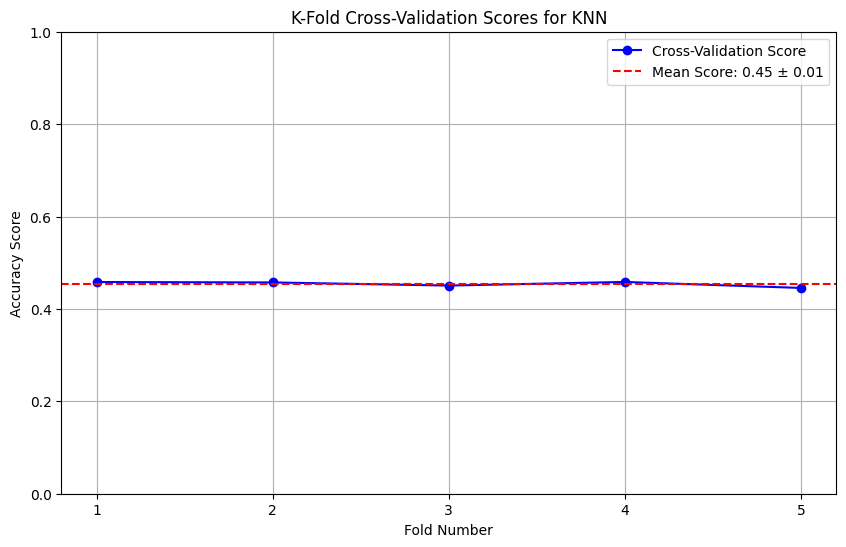

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example K-Fold Cross-Validation scores
cv_scores = np.array([0.45820272, 0.45733194, 0.45053988, 0.45837687, 0.44539279])  # Replace with your scores
mean_score = np.mean(cv_scores)
std_score = np.std(cv_scores)

# Create a plot for K-Fold Cross-Validation Scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='-', color='blue', label='Cross-Validation Score')
plt.axhline(mean_score, color='red', linestyle='--', label=f'Mean Score: {mean_score:.2f} ± {std_score:.2f}')

# Adding labels and title
plt.title('K-Fold Cross-Validation Scores for KNN')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy Score')
plt.xticks(range(1, len(cv_scores) + 1))
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.legend()
plt.grid()

# Show the plot
plt.show()
